<a href="https://colab.research.google.com/github/Unoaccaso/ML_final_project/blob/master/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf * # warning
!wget https://www.dropbox.com/s/grorylbv44zm4na/beta-beta-decay-identification.zip?dl=1 -O archive.zip
!unzip archive.zip
!7z x beta-beta-decay-identification/data_train.csv.zip -so > data_train.csv
!7z x beta-beta-decay-identification/labels_train.csv.zip -so > labels_train.csv
!rm -rf __MACOSX beta-beta-decay-identification archive.zip

--2020-06-11 09:50:10--  https://www.dropbox.com/s/grorylbv44zm4na/beta-beta-decay-identification.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/grorylbv44zm4na/beta-beta-decay-identification.zip [following]
--2020-06-11 09:50:10--  https://www.dropbox.com/s/dl/grorylbv44zm4na/beta-beta-decay-identification.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7c706846d961b1a57b1d8d64fe.dl.dropboxusercontent.com/cd/0/get/A5eqpzuOMvrZo3X03zjGvaruUvXifh6IhpY8geulMBbW5bhLsleo92VXvqz48gSGaZ0v4wDRsfw-lVJ_l7j8Bt6aZFU9Hc_K7Mhzn36K17nCvbGkWDLDbjQ2kfw7WYbrXX4/file?dl=1# [following]
--2020-06-11 09:50:10--  https://uc7c706846d961b1a57b1d8d64fe.dl.dropboxusercontent.com/cd/0/get/A5eqpzuOMvrZo3X03zjGvaruUvXifh6IhpY8geulMBb

In [0]:
import numpy as np
import cupy as cp
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
from IPython.display import HTML, display
import time

In [0]:
data_train = pd.read_csv('data_train.csv')
labels_train = pd.read_csv('labels_train.csv')

In [0]:
def create_images(data, n_theta_bins=10, n_phi_bins=20, n_time_bins=6):
    labels = []
    images = []
    event_indexes = {}
    event_ids = np.unique(data['EventID'].values)
    
    # collect event indexes
    data_event_ids = data['EventID'].values
    for i in range(len(data)):
        i_event = data_event_ids[i]
        if i_event in event_indexes:
            event_indexes[i_event].append(i)
        else:
            event_indexes[i_event] = [i]
            
    # create images
    for i, i_event in tqdm(enumerate(event_ids)):
        event = data.iloc[event_indexes[i_event]]
        X = event[['Theta', 'Phi', 'Time']].values
        one_image, edges = np.histogramdd(X, 
                                          bins=(n_theta_bins, n_phi_bins, n_time_bins))
        images.append(one_image)
        label = labels_train[labels_train["EventID"]==i_event]["Label"].values[0]
        labels.append(label)
    return (np.array(images), np.array(labels))

In [5]:
images, labels = create_images(data_train,
                               n_theta_bins=10, 
                               n_phi_bins=20, 
                               n_time_bins=6)

80000it [03:37, 367.20it/s]


In [6]:
print(images.shape)
print(labels.shape)

(80000, 10, 20, 6)
(80000,)


# Data manipulation

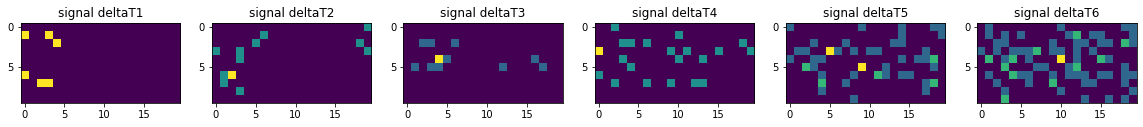

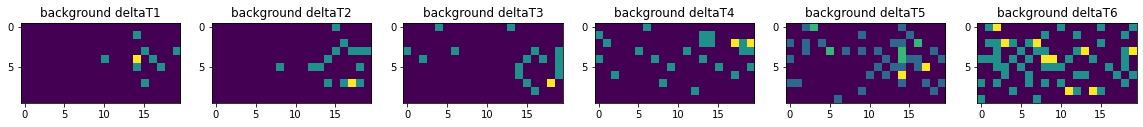

In [7]:
signal = images[labels == 1]
background = images[labels == 0]

sig = np.random.randint(0, signal.shape[0])
back = np.random.randint(0, background.shape[0])

plt.figure(figsize=(20, 10))
for i in range(6):
  plt.subplot(1, 6, i+1)
  plt.imshow(signal[sig][:, :, i])
  plt.title(f'signal deltaT{i+1}')
plt.show()
plt.figure(figsize=(20, 10))
for i in range(6):
  plt.subplot(1, 6, i+1)
  plt.imshow(background[back][:, :, i])
  plt.title(f'background deltaT{i+1}')
plt.show()

# NN training

In [0]:
from sklearn.model_selection import train_test_split
(X_train, X_test, Y_train, Y_test) = train_test_split(images, labels, test_size=0.1)

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [10]:
print(X_train.shape)
print(Y_train.shape)

(72000, 10, 20, 6)
(72000,)


In [77]:
IMG_SHAPE = (10, 20, 6)

img_input = keras.Input(shape=IMG_SHAPE, name="D_Image_Input")
x = img_input

# primo blocco Convoluzionale
x = keras.layers.Conv2D(filters=16, kernel_size=(3, 5),name='Conv_1')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU(name='ReLU_1')(x)
x = layers.Dropout(0.12, name="DropOut_1")(x)

# secondo blocco Convoluzionale
x = keras.layers.Conv2D(filters=32, kernel_size=(3, 4), name='Conv_2')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU(name='ReLU_2')(x)
x = layers.Dropout(0.12, name="DropOut_2")(x)

# terzo blocco Convoluzionale
x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), name='Conv_3')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU(name='ReLU_3')(x)
x = layers.Dropout(0.12, name="DropOut_3")(x)

x = keras.layers.Flatten(name='Flatten')(x)

# layer densi
x = keras.layers.Dense(64, name='Dense_1')(x)
x = layers.Dropout(0.2, name="DropOut_4")(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)

outputs = keras.layers.Dense(1, activation='sigmoid', name='Output')(x)

model = keras.Model(inputs=img_input, outputs=outputs, name='predictor')

#printout il summary del modello
model.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
D_Image_Input (InputLayer)   [(None, 10, 20, 6)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 8, 16, 16)         1456      
_________________________________________________________________
batch_normalization_58 (Batc (None, 8, 16, 16)         64        
_________________________________________________________________
ReLU_1 (ReLU)                (None, 8, 16, 16)         0         
_________________________________________________________________
DropOut_1 (Dropout)          (None, 8, 16, 16)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 6, 13, 32)         6176      
_________________________________________________________________
batch_normalization_59 (Batc (None, 6, 13, 32)         12

In [78]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='cnn_best',
        monitor='val_accuracy',
        save_weights_only=True, 
        save_best_only=True,
        save_freq='epoch')

# metto tutte le callback in una lista
callbacks = [ model_checkpoint ]     

model.compile(loss="binary_crossentropy", optimizer='adam', 
              metrics=["accuracy",
                       keras.metrics.AUC(name='auc')])
history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=256, 
          epochs=20, shuffle=True, verbose=1, callbacks=callbacks)

Epoch 1/20
254/254 [==============================] - 4s 14ms/step - loss: 0.6561 - accuracy: 0.6005 - auc: 0.6491 - val_loss: 0.6369 - val_accuracy: 0.6250 - val_auc: 0.8043
Epoch 2/20
254/254 [==============================] - 3s 12ms/step - loss: 0.5459 - accuracy: 0.7315 - auc: 0.7995 - val_loss: 0.5945 - val_accuracy: 0.6737 - val_auc: 0.8250
Epoch 3/20
254/254 [==============================] - 3s 12ms/step - loss: 0.5237 - accuracy: 0.7491 - auc: 0.8185 - val_loss: 0.5017 - val_accuracy: 0.7608 - val_auc: 0.8380
Epoch 4/20
254/254 [==============================] - 3s 12ms/step - loss: 0.5137 - accuracy: 0.7552 - auc: 0.8261 - val_loss: 0.5112 - val_accuracy: 0.7489 - val_auc: 0.8405
Epoch 5/20
254/254 [==============================] - 3s 12ms/step - loss: 0.5091 - accuracy: 0.7588 - auc: 0.8298 - val_loss: 0.5341 - val_accuracy: 0.7353 - val_auc: 0.8456
Epoch 6/20
254/254 [==============================] - 3s 12ms/step - loss: 0.5046 - accuracy: 0.7629 - auc: 0.8336 - val_loss

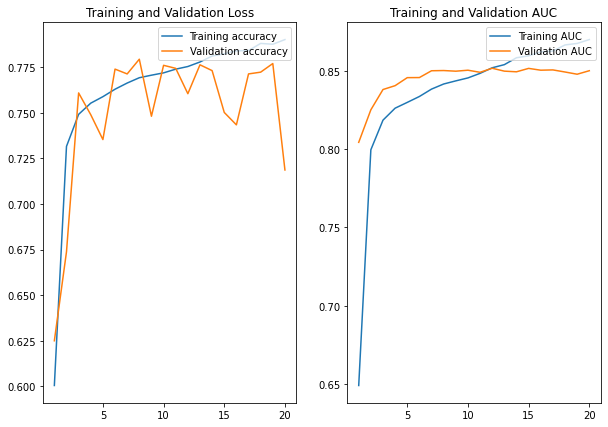

Results on test:
Loss:		0.505
Accuracy:	0.761
AUC:		0.835


In [79]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']

AUC=history.history['auc']
val_AUC=history.history['val_auc']

epochs_range = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, AUC, label='Training AUC')
plt.plot(epochs_range, val_AUC, label='Validation AUC')
plt.legend(loc='upper right')
plt.title('Training and Validation AUC')

plt.show()

model.load_weights('cnn_best')
loss, accuracy, AUC = model.evaluate(X_test, Y_test, verbose=0)
print('Results on test:')
print(f'Loss:\t\t{loss:.3f}')
print(f'Accuracy:\t{accuracy:.3f}')
print(f'AUC:\t\t{AUC:.3f}')